In [1]:
import numpy as np
import scipy as sp
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lgcg'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from lgcg import LGCG

# Heat Equation

## Generate Data and Define Functions

In [2]:
# Omega = np.array([[0,1]])
# alpha = 1e-5
# observation_resolution = 9
# std_factor = 0.02
# true_sources = np.array([[0.25], [0.57], [0.77]])
# true_weights = np.array([1, 0.7, -0.7])

# Omega = np.array([[0,1], [0,1]])
# alpha = 1e-1
# observation_resolution = 4
# std_factor = 0.1
# true_sources = np.array([[0.28, 0.31], [0.51,0.73]])
# true_weights = np.array([1,1])

Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [3]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])
k = lambda x: np.array([np.exp(-np.linalg.norm(point-x)**2/std_factor)/np.sqrt(std_factor*np.pi)**Omega.shape[0] for point in observations])
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(k)

In [4]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(sum(c * k(x) for x, c in zip(u.support, u.coefficients)) - target) ** 2

In [5]:
def p_raw(u, k, target):
    def p_u(x):
        Ku = u.duality_pairing(k)
        inner = Ku-target
        return -np.dot(inner, k(x))
    return p_u

p = lambda u: p_raw(u, k=k, target=target)

In [6]:
def grad_k_raw(observations, std_factor):
    def grad_k(x):
        return np.array([2*(point-x)*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]) for point in observations])
    return grad_k

grad_k = grad_k_raw(observations, std_factor) # The Jacobian of k, shape=(len(observations), Omega.shape[0])

In [7]:
def hess_k_raw(observations, std_factor):
    def hess_k(x):
        first_part = lambda point: -2*np.eye(Omega.shape[0])*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        second_part = lambda point: 4*np.dot((point-x).reshape(-1,1), np.array([point-x]))*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        return np.array([first_part(point)+second_part(point) for point in observations])
    return hess_k

hess_k = hess_k_raw(observations, std_factor) # The derivative of the Jacobian of k, shape=(len(observations), Omega.shape[0], Omega.shape[0])

In [8]:
def grad_P_raw(k, target, observations, std_factor):
    grad_k = grad_k_raw(observations, std_factor)
    def grad_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.sign(p_u(x))*np.matmul(grad_k(x).T, inner)
    return grad_P

grad_P = grad_P_raw(k, target, observations, std_factor)

In [9]:
def hess_P_raw(k, target, observations, std_factor):
    hess_k = hess_k_raw(observations, std_factor)
    def hess_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0]))
    return hess_P

hess_P = hess_P_raw(k, target, observations, std_factor)

In [10]:
def get_grad_j(k, grad_k, alpha, target):
    def grad_j(positions, coefs):
        to_return = []
        grad_F = (
            np.sum(
                np.array([c * k(x) for x, c in zip(positions, coefs)]),
                axis=0,
            )
            - target
        )
        for ind, x in enumerate(positions):
            # nabla_x_ind
            array = coefs[ind] * np.matmul(grad_k(x).T, grad_F)
            to_return += array.tolist()
        # nabla_u
        K = np.array([k(x) for x in positions])
        to_return += (np.dot(K, grad_F) + alpha * np.sign(coefs)).tolist()
        return np.array(to_return)
    return grad_j

grad_j = get_grad_j(k, grad_k, alpha, target)

In [11]:
def get_hess_j(k, grad_k, hess_k, target):
    def hess_j(positions, coefs):
        matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
        hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
        step = Omega.shape[0]
        coefs_delay = step*len(positions)
        inner = sum(k(x)*c for c, x in zip(coefs, positions))-target
        for i, position in enumerate(positions):
            # nabla_{x_i,x_j}
            for j, other_position in enumerate(positions):
                if j<i:
                    continue
                block = coefs[i]*coefs[j]*np.matmul(grad_k(position).T, grad_k(other_position))
                if i==j:
                    block += coefs[i]*np.tensordot(hess_k(position),inner,axes=([0,0]))
                hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
                hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
            # nabla_{x_i,u_j}
            for j, coef in enumerate(coefs):
                block = coefs[i]*np.matmul(grad_k(position).T, k(positions[j]))
                if i == j:
                    block += np.matmul(grad_k(position).T, inner)
                hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
                hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
        for i, coef in enumerate(coefs):
            # nabla_{u_i,u_j}
            for j, other_coef in enumerate(coefs):
                if j<i:
                    continue
                block = np.dot(k(positions[i]), k(positions[j]))
                hesse_matrix[coefs_delay+i,coefs_delay+j] = block
                hesse_matrix[coefs_delay+j,coefs_delay+i] = block
        return hesse_matrix
    return hess_j

hess_j = get_hess_j(k, grad_k, hess_k, target)

In [12]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = [np.linalg.norm(k(np.array([x]))) for x in a]
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    vals = [np.linalg.norm(k(np.array([x_1,x_2]))) for x_1, x_2 in zip(B.flatten(), D.flatten())]
norm_K_star = max(vals) # ||k([0.5,0.5])||

In [13]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = [np.linalg.norm(grad_k(np.array([x]))) for x in a]
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    vals = [np.linalg.norm(grad_k(np.array([x_1,x_2]))) for x_1, x_2 in zip(B.flatten(), D.flatten())]
norm_K_star_L = max(vals)

In [14]:
gamma = 0.5
theta = 1e-1
sigma = 2e-3
m = 1e-3
bar_m = 1e-1
L = 1
R = 1e-2

## Experiments

In [15]:
exp = LGCG(target=target, 
           k=k, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           R=R
           )

In [27]:
u, P_values, objective_values = exp.solve_exact(tol=1e-12)

DEBUG:root:SSN in 1 dimensions converged in 1 iterations to tolerance 1.000E-12
INFO:root:1: P_value:1.270E+01, support: [[0.44043758 0.69141257]], coefs: [1.05279812], x: [0.42427898 0.23939056], valid: False
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:2: P_value:6.123E+00, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]], coefs: [-0.46886794  1.23385151], x: [0.83741191 0.49779621], valid: False
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:3: P_value:4.981E+00, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741191 0.49779621]], coefs: [-0.53679209  1.13760922  0.3139453 ], x: [0.14118912 0.63968789], valid: False
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:r

In [28]:
objective_values-boss

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903638e+00,
       2.29592885e-01, 1.29111897e-01, 6.02585417e-02, 5.81289512e-02,
       5.43698664e-02, 4.28609944e-02, 2.43456503e-02, 2.24655447e-02,
       2.19692474e-02, 1.97512428e-02, 1.45352923e-02, 1.17524223e-02,
       8.37236236e-03, 8.03803948e-03, 7.27480817e-03, 5.49766975e-03,
       4.74499617e-03, 4.33283652e-03, 3.06984440e-03, 3.03428461e-03,
       2.57014229e-03, 2.25412124e-03, 2.23311040e-03, 1.77761552e-03,
       1.74648412e-03, 1.02712752e-03, 1.00858186e-03, 7.05155841e-04,
       4.57693628e-04, 3.73211916e-04, 3.33190542e-04, 3.26993184e-04,
       3.19892888e-04, 2.76245308e-04, 2.23204463e-04, 2.02454711e-04,
       1.54178705e-04, 1.15907914e-04, 8.63986385e-05, 6.07054397e-05,
       5.67244719e-05, 4.57620932e-05, 4.45954995e-05, 4.10285757e-05,
       3.04742176e-05, 1.81642187e-05, 1.30620068e-05, 1.09290638e-05,
       1.01611281e-05, 9.32029227e-06, 8.04407469e-06, 5.27262720e-06,
      

In [29]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322617 0.71433129]
 [0.28322854 0.7143316 ]
 [0.28322907 0.71433075]
 [0.49565837 0.23548634]
 [0.49565934 0.23548554]
 [0.73058702 0.54790215]
 [0.7305891  0.54790166]
 [0.73058945 0.54790038]] and coefficients [ 0.57002759  0.30609638  0.11956745 -0.59834719 -0.01923366  0.34713359
  0.03405803  0.33094083]
1.662558979376172e-14
-8.604228440844963e-16


In [16]:
u, grad_norms, objective_values = exp.solve_newton(tol=1e-12, damped=False)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 5.096E-06
INFO:root:1: gcg, support: [[0.44043758 0.69141257]], coefs: [1.05279812], grad_norm:2.174E+01, objective: 5.807E+00
DEBUG:root:SSN in 2 dimensions converged in 1 iterations to tolerance 2.548E-06
INFO:root:2: gcg, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]], coefs: [-0.46886804  1.23385155], grad_norm:8.729E+00, objective: 2.829E+00
DEBUG:root:SSN in 3 dimensions converged in 1 iterations to tolerance 1.274E-06
INFO:root:3: gcg, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741189 0.49779617]], coefs: [-0.53679211  1.13760922  0.31394532], grad_norm:2.422E+01, objective: 1.868E+00
DEBUG:root:SSN in 4 dimensions converged in 1 iterations to tolerance 6.370E-07
INFO:root:4: gcg, support: [[0.14118912 0.63968788]
 [0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741189 0.49779617]], coefs: [ 0.56193763 -0.62011121  0.77396863  0.47872382], grad_norm:4.354E+00, objectiv

In [17]:
boss = objective_values[-1]

In [18]:
objective_values-boss

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903642e+00,
       2.29592990e-01, 1.29111932e-01, 6.02585534e-02, 5.81289612e-02,
       5.43698732e-02, 4.28609927e-02, 2.43456069e-02, 2.24655086e-02,
       2.19692082e-02, 1.97512139e-02, 1.45352674e-02, 1.17524036e-02,
       8.37239885e-03, 8.03808360e-03, 7.27483454e-03, 5.49772562e-03,
       4.74502394e-03, 4.33287731e-03, 3.06986962e-03, 3.03430966e-03,
       2.57016095e-03, 2.25416046e-03, 2.23314682e-03, 1.77758027e-03,
       1.74647208e-03, 1.02710256e-03, 2.10966354e-05, 1.51058264e-05,
       2.82709689e-10, 0.00000000e+00, 0.00000000e+00])

In [19]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
5.986877660291157e-14
3.502753642692369e-14


In [20]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([402.39077637, 272.29702435, 194.35314107,  68.45550406,
        48.27005106,   1.82700374,   7.42624617,  18.87504406,
        24.25981579])

In [21]:
u, grad_norms, objective_values = exp.solve_newton(tol=1e-12, damped=True)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 5.096E-06
INFO:root:1: gcg, support: [[0.44043758 0.69141257]], coefs: [1.05279812], grad_norm:2.174E+01, objective: 5.807E+00
DEBUG:root:SSN in 2 dimensions converged in 1 iterations to tolerance 2.548E-06
INFO:root:2: gcg, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]], coefs: [-0.46886804  1.23385155], grad_norm:8.729E+00, objective: 2.829E+00
DEBUG:root:SSN in 3 dimensions converged in 1 iterations to tolerance 1.274E-06
INFO:root:3: gcg, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741189 0.49779617]], coefs: [-0.53679211  1.13760922  0.31394532], grad_norm:2.422E+01, objective: 1.868E+00
DEBUG:root:SSN in 3 dimensions converged in 1 iterations to tolerance 5.096E-06
INFO:root:4: newton, support: [[0.41382093 0.66314804]
 [0.45918859 0.31637916]
 [0.87381301 0.50175144]], coefs: [ 1.25186813 -0.66351344  0.48339649], grad_norm:1.817E+01, objective: 1.087E+00
DEBUG:root:SSN in 3 d

In [22]:
objective_values-boss

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903642e+00,
       8.47728956e-01, 6.70798629e-01, 5.29852103e-01, 4.12011062e-01,
       3.11021042e-01, 2.24405755e-01, 1.52490459e-01, 9.63926672e-02,
       5.59330910e-02, 2.91602755e-02, 1.31493710e-02, 4.79875731e-03,
       1.25693718e-03, 1.86690390e-04, 9.35660835e-06, 4.58474398e-08,
       1.44023682e-12, 0.00000000e+00])

In [23]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
9.724125671350947e-11
-7.623290887437406e-11


In [24]:
u, Phi_ks, objective_values = exp.solve(tol=1e-12)

INFO:root:1: N/A, Phi_k: 381.74392262753315, epsilon: 393.73810553231726 support: []
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 5.096E-06
INFO:root:2: LSI, False, Phi_k: 127.00847853601472, epsilon: 497.8139826983301 support: [[0.44043758 0.69141257]]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 1 iterations to tolerance 5.096E-06
INFO:root:3: LSI, False, Phi_k: 61.229294600238816, epsilon: 507.9913326709468 support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 1 iterations to tolerance 5.096E-06
INFO:root:4: LSI, False, Phi_k: 49.807795603415954, epsilon: 486.3604140778353 support: [[0.42427898 0.23939056]
 [0.44043758 0.69141257]
 [0.83741188 0.49779613]]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions

In [26]:
objective_values-boss

array([2.56626430e+01, 2.56626430e+01, 5.56767886e+00, 2.59016866e+00,
       1.62903645e+00, 2.29593103e-01, 1.29111984e-01, 6.02585728e-02,
       6.02585728e-02, 6.02585728e-02, 5.81289767e-02, 5.81289767e-02,
       5.81289767e-02, 5.43698855e-02, 4.28609923e-02, 4.28609923e-02,
       2.43455664e-02, 2.24654754e-02, 2.19691713e-02, 2.19691713e-02,
       2.19691713e-02, 1.97511875e-02, 1.97511875e-02, 1.45352426e-02,
       1.17523849e-02, 1.17523849e-02, 1.17523849e-02, 8.37243218e-03,
       8.03812391e-03, 7.27485867e-03, 7.27485867e-03, 5.49777791e-03,
       4.74504951e-03, 4.33291539e-03, 3.06989304e-03, 3.06989304e-03,
       3.06989304e-03, 3.03433290e-03, 2.57017829e-03, 2.57017829e-03,
       2.25419735e-03, 2.23318109e-03, 2.23318109e-03, 1.77754830e-03,
       1.74646153e-03, 1.74646153e-03, 1.02707928e-03, 1.00857325e-03,
       1.00857325e-03, 7.05214827e-04, 7.05214827e-04, 4.57750509e-04,
       4.57750509e-04, 3.73036043e-04, 3.33280765e-04, 3.33280765e-04,
      

In [25]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322715 0.71433141]
 [0.28322739 0.71433124]
 [0.28322753 0.71433104]
 [0.28322791 0.71433135]
 [0.49565818 0.23548641]
 [0.49565835 0.23548633]
 [0.49565835 0.23548631]
 [0.49565843 0.23548614]
 [0.73058825 0.54790128]
 [0.7305883  0.54790144]
 [0.73058834 0.54790148]
 [0.73058906 0.54790105]] and coefficients [ 0.71175986  0.05215438  0.19788309  0.03389408 -0.08658738 -0.0042527
 -0.10985479 -0.41688584  0.36502673  0.30341828  0.00255166  0.04113562]
4.9932280532516415e-14
2.5729418595688003e-14


## Plots

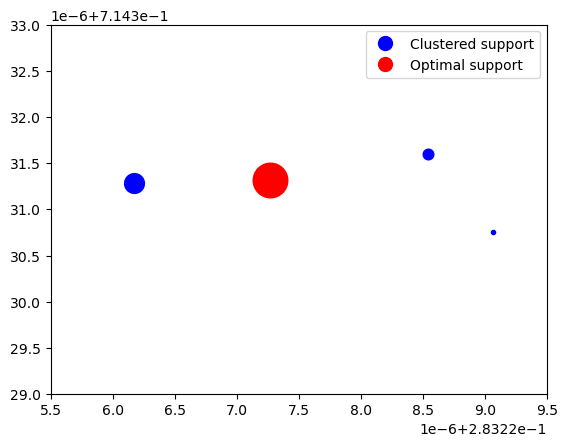

In [26]:
clustered_points = [[0.28322617, 0.71433129], [0.28322854, 0.7143316], [0.28322907, 0.71433075]]
clustered_weights = [0.57002759,  0.30609638,  0.11956745]
true_point = [0.28322727, 0.71433132]
true_weight = 0.99569143
plt.plot(0,0,"o", c="b", markersize=10,label="Clustered support"); # Point for legend
plt.plot(0,0,"o", c="r", markersize=10,label="Optimal support"); # Point for legend
for (x,c) in zip(clustered_points, clustered_weights):
    plt.plot(x[0], x[1], "o", c="b", markersize=25*c);
plt.plot(true_point[0], true_point[1], "o", c="r", markersize=25*true_weight);
plt.ylim(7.14331e-1-2e-6, 7.14331e-1+2e-6)
plt.xlim(2.832275e-1-2e-6, 2.832275e-1+2e-6)
plt.legend(fontsize=10);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f4a0448afb0>


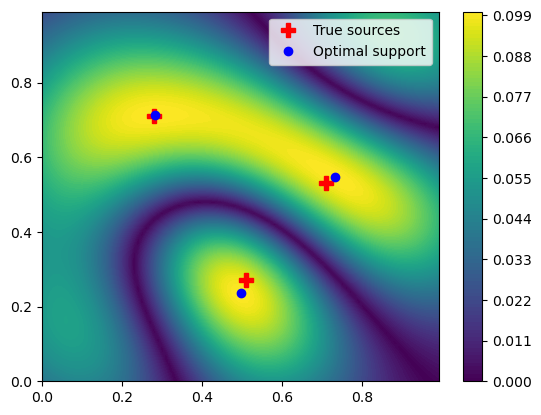

In [47]:
u_tilde = u # Measure(support=[[0.15726501,0.32474335]], coefficients=[0.8985414])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
for i, x in enumerate(true_sources):
    if i:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10);
    else:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10, label="True sources");
for i, x in enumerate(u_tilde.support):
    if i:
        plt.plot([x[0]], [x[1]], "o", c="b");
    else:
        plt.plot([x[0]], [x[1]], "o", c="b", label="Optimal support");
plt.legend();

In [ ]:
residuals_exact = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903638e+00,
       2.29592885e-01, 1.29111897e-01, 6.02585417e-02, 5.81289512e-02,
       5.43698664e-02, 4.28609944e-02, 2.43456503e-02, 2.24655447e-02,
       2.19692474e-02, 1.97512428e-02, 1.45352923e-02, 1.17524223e-02,
       8.37236236e-03, 8.03803948e-03, 7.27480817e-03, 5.49766975e-03,
       4.74499617e-03, 4.33283652e-03, 3.06984440e-03, 3.03428461e-03,
       2.57014229e-03, 2.25412124e-03, 2.23311040e-03, 1.77761552e-03,
       1.74648412e-03, 1.02712752e-03, 1.00858186e-03, 7.05155841e-04,
       4.57693628e-04, 3.73211916e-04, 3.33190542e-04, 3.26993184e-04,
       3.19892888e-04, 2.76245308e-04, 2.23204463e-04, 2.02454711e-04,
       1.54178705e-04, 1.15907914e-04, 8.63986385e-05, 6.07054397e-05,
       5.67244719e-05, 4.57620932e-05, 4.45954995e-05, 4.10285757e-05,
       3.04742176e-05, 1.81642187e-05, 1.30620068e-05, 1.09290638e-05,
       1.01611281e-05, 9.32029227e-06, 8.04407469e-06, 5.27262720e-06,
       4.24369499e-06, 3.14383914e-06, 2.27072545e-06, 2.09975092e-06,
       1.54883193e-06, 1.32261948e-06, 1.21835927e-06, 7.01073175e-07,
       5.11830062e-07, 4.95686525e-07, 2.81827749e-07, 2.65685152e-07,
       2.43762479e-07, 2.04708867e-07, 1.51841890e-07, 1.42688761e-07,
       1.19808856e-07, 1.02366626e-07, 8.53888051e-08, 6.42332173e-08,
       4.01437313e-08, 2.98568201e-08, 2.80246222e-08, 2.70264029e-08,
       1.82394593e-08, 1.71864692e-08, 1.23224583e-08, 1.19299871e-08,
       1.04193539e-08, 9.07621023e-09, 4.51238477e-09, 2.88110863e-09,
       2.25472893e-09, 1.86074270e-09, 1.78180218e-09, 1.54573246e-09,
       1.40785317e-09, 7.34020095e-10, 5.61969471e-10, 5.41426154e-10,
       4.68973832e-10, 3.81629006e-10, 3.13355897e-10, 2.91492885e-10,
       1.64648795e-10, 1.19685456e-10, 1.13675541e-10, 1.05316977e-10,
       6.83093859e-11, 6.58481603e-11, 5.69894687e-11, 3.59374197e-11,
       3.26562666e-11, 3.13570003e-11, 2.85296509e-11, 2.65147904e-11,
       2.01146599e-11, 1.93611516e-11, 1.09573739e-11, 6.94158619e-12,
       5.62846991e-12, 4.33350578e-12, 4.09142165e-12, 3.25628413e-12,
       3.00329206e-12, 2.56469845e-12, 1.42208467e-12, 1.36807232e-12,
       9.89930360e-13])

residuals_newton = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903642e+00,
       2.29592990e-01, 1.29111932e-01, 6.02585534e-02, 5.81289612e-02,
       5.43698732e-02, 4.28609927e-02, 2.43456069e-02, 2.24655086e-02,
       2.19692082e-02, 1.97512139e-02, 1.45352674e-02, 1.17524036e-02,
       8.37239885e-03, 8.03808360e-03, 7.27483454e-03, 5.49772562e-03,
       4.74502394e-03, 4.33287731e-03, 3.06986962e-03, 3.03430966e-03,
       2.57016095e-03, 2.25416046e-03, 2.23314682e-03, 1.77758027e-03,
       1.74647208e-03, 1.02710256e-03, 2.10966354e-05, 1.51058264e-05,
       2.82709689e-10, 0.00000000e+00, 0.00000000e+00])

residuals_newton_damped = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903642e+00,
       8.47728956e-01, 6.70798629e-01, 5.29852103e-01, 4.12011062e-01,
       3.11021042e-01, 2.24405755e-01, 1.52490459e-01, 9.63926672e-02,
       5.59330910e-02, 2.91602755e-02, 1.31493710e-02, 4.79875731e-03,
       1.25693718e-03, 1.86690390e-04, 9.35660835e-06, 4.58474398e-08,
       1.44023682e-12, 0.00000000e+00])

residuals_lpdap = np.array([2.56626430e+01, 2.56626430e+01, 5.56767886e+00, 2.59016866e+00,
       1.62903645e+00, 2.29593103e-01, 1.29111984e-01, 6.02585728e-02,
       6.02585728e-02, 6.02585728e-02, 5.81289767e-02, 5.81289767e-02,
       5.81289767e-02, 5.43698855e-02, 4.28609923e-02, 4.28609923e-02,
       2.43455664e-02, 2.24654754e-02, 2.19691713e-02, 2.19691713e-02,
       2.19691713e-02, 1.97511875e-02, 1.97511875e-02, 1.45352426e-02,
       1.17523849e-02, 1.17523849e-02, 1.17523849e-02, 8.37243218e-03,
       8.03812391e-03, 7.27485867e-03, 7.27485867e-03, 5.49777791e-03,
       4.74504951e-03, 4.33291539e-03, 3.06989304e-03, 3.06989304e-03,
       3.06989304e-03, 3.03433290e-03, 2.57017829e-03, 2.57017829e-03,
       2.25419735e-03, 2.23318109e-03, 2.23318109e-03, 1.77754830e-03,
       1.74646153e-03, 1.74646153e-03, 1.02707928e-03, 1.00857325e-03,
       1.00857325e-03, 7.05214827e-04, 7.05214827e-04, 4.57750509e-04,
       4.57750509e-04, 3.73036043e-04, 3.33280765e-04, 3.33280765e-04,
       3.27077576e-04, 3.19989605e-04, 3.19989605e-04, 2.76573064e-04,
       2.22966500e-04, 2.22966500e-04, 2.02053148e-04, 1.53862372e-04,
       1.53862372e-04, 1.15136528e-04, 8.57193689e-05, 6.10054815e-05,
       5.67660748e-05, 4.60855936e-05, 4.49138025e-05, 4.12154523e-05,
       3.02955298e-05, 1.79043997e-05, 1.29899797e-05, 1.09687780e-05,
       1.00183996e-05, 9.17376534e-06, 8.12579402e-06, 5.21701536e-06,
       4.25299079e-06, 3.24514839e-06, 2.32686159e-06, 2.07458221e-06,
       1.55265843e-06, 1.28775985e-06, 1.12939552e-06, 6.63447885e-07,
       5.61885763e-07, 5.37056136e-07, 3.27591064e-07, 2.32375973e-07,
       1.27945780e-07, 6.23795848e-08, 2.62178001e-08, 2.27889758e-08,
       3.91815735e-09, 3.16376045e-09, 2.83159254e-09, 2.08785367e-09,
       1.41097128e-09, 6.06083739e-10, 3.22822241e-10, 2.85006962e-10,
       2.31919400e-10, 1.70202658e-10, 1.03029418e-10, 4.19157209e-11,
       3.73088227e-11, 3.01776937e-11, 2.89521740e-11, 2.46224152e-11,
       1.67302006e-11, 8.61319349e-12, 3.37818662e-12, 2.10761963e-12,
       1.98174810e-12, 8.52068416e-13, 5.88057381e-13, 2.84522406e-13,
       1.47881707e-13, 9.46465128e-14, 8.82904860e-14])

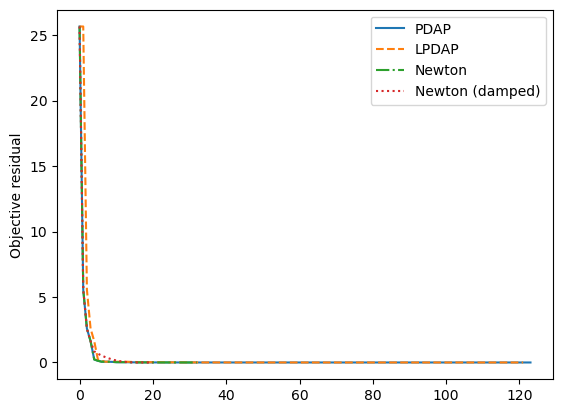

In [7]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
for array, name, style in zip([residuals_exact, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 26);
plt.legend();

# Signal Processing

## Generate Data and Define Functions

In [2]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [3]:
observations = np.arange(0,1,1/observation_resolution)
k = lambda x: np.array([np.sin(2*np.pi*x[0]*t) for t in observations])
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(k)

In [4]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(k) - target) ** 2

In [5]:
def p_raw(u, k, target):
    def p_u(x):
        Ku = u.duality_pairing(k)
        inner = Ku-target
        return -np.dot(inner, k(x))
    return p_u

p = lambda u: p_raw(u, k=k, target=target)

In [6]:
def grad_k_raw(observations):
    def grad_k(x):
        return np.array([[2*np.pi*t*np.cos(2*np.pi*x[0]*t) for t in observations]]).T
    return grad_k

grad_k = grad_k_raw(observations) # The Jacobian of k, shape=(len(observations),Omega.shape[0])

In [7]:
def hess_k_raw(observations):
    def hess_k(x):
        return np.transpose(np.array([[[-4*np.pi**2*t**2*np.sin(2*np.pi*x[0]*t) for t in observations]]]), axes=(2,0,1))
    return hess_k

hess_k = hess_k_raw(observations) # The Hessian of k, shape=(len(observations),Omega.shape[0],Omega.shape[0])

In [8]:
def grad_P_raw(k, target, observations):
    grad_k = grad_k_raw(observations)
    def grad_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.array(np.sign(p_u(x))*np.matmul(grad_k(x).T, inner))
    return grad_P

grad_P = grad_P_raw(k, target, observations)

In [9]:
def hess_P_raw(k, target, observations):
    hess_k = hess_k_raw(observations)
    def hess_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.array(np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0])))
    return hess_P

hess_P = hess_P_raw(k, target, observations)

In [10]:
def get_grad_j(k, grad_k, alpha, target):
    def grad_j(positions, coefs):
        to_return = []
        grad_F = (
            np.sum(
                np.array([c * k(x) for x, c in zip(positions, coefs)]),
                axis=0,
            )
            - target
        )
        for ind, x in enumerate(positions):
            # nabla_x_ind
            array = coefs[ind] * np.matmul(grad_k(x).T, grad_F)
            to_return += array.tolist()
        # nabla_u
        K = np.array([k(x) for x in positions])
        to_return += (np.dot(K, grad_F) + alpha * np.sign(coefs)).tolist()
        return np.array(to_return)
    return grad_j

grad_j = get_grad_j(k, grad_k, alpha, target)

In [11]:
def get_hess_j(k, grad_k, hess_k, target):
    def hess_j(positions, coefs):
        matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
        hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
        step = Omega.shape[0]
        coefs_delay = step*len(positions)
        inner = sum(k(x)*c for c, x in zip(coefs, positions))-target
        for i, position in enumerate(positions):
            # nabla_{x_i,x_j}
            for j, other_position in enumerate(positions):
                if j<i:
                    continue
                block = coefs[i]*coefs[j]*np.matmul(grad_k(position).T, grad_k(other_position))
                if i==j:
                    block += coefs[i]*np.tensordot(hess_k(position),inner,axes=([0,0]))
                hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
                hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
            # nabla_{x_i,u_j}
            for j, coef in enumerate(coefs):
                block = coefs[i]*np.matmul(grad_k(position).T, k(positions[j]))
                if i == j:
                    block += np.matmul(grad_k(position).T, inner)
                hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
                hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
        for i, coef in enumerate(coefs):
            # nabla_{u_i,u_j}
            for j, other_coef in enumerate(coefs):
                if j<i:
                    continue
                block = np.dot(k(positions[i]), k(positions[j]))
                hesse_matrix[coefs_delay+i,coefs_delay+j] = block
                hesse_matrix[coefs_delay+j,coefs_delay+i] = block
        return hesse_matrix
    return hess_j

hess_j = get_hess_j(k, grad_k, hess_k, target)

In [12]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1)
vals = [np.linalg.norm(k(np.array([x]))) for x in a]
norm_K_star = max(vals)

In [13]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1)
vals = [np.linalg.norm(grad_k(np.array([x]))) for x in a]
norm_K_star_L = max(vals)

In [14]:
gamma = 0.5
theta = 1e-1
sigma = 5e-2
m = 1e-3
bar_m = 1e-1
L = 1
R = 1e-1

## Experiments

In [15]:
exp = LGCG(target=target, 
           k=k, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           R=R,
           global_search_resolution=observation_resolution
           )

In [16]:
u, P_values, objective_values = exp.solve_exact(tol=1e-12)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:1: P_value:4.205E+01, support: [[3.13588856]], coefs: [-1.02219696], x: [7.00005078], valid: False
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:2: P_value:2.994E+01, support: [[3.13588856]
 [7.00005078]], coefs: [-0.99145093  0.70208178], x: [13.38203765], valid: False
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:3: P_value:1.804E+00, support: [[ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.99785308  0.69586351  0.49867157], x: [2.81555416], valid: False
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:4: P_value:7.835E-01, support: [[ 2.81555416]
 [ 3.13588856]
 [ 7.00005078]
 [13.38203765]

In [17]:
objective_values[-5:]

[0.21975386261001495,
 0.21975386260640103,
 0.21975386260440813,
 0.21975386260348206,
 0.21975386260166965]

In [23]:
boss

0.2197538626001237

In [22]:
objective_values-boss

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       4.42212683e-07, 3.05311332e-16, 0.00000000e+00, 0.00000000e+00])

In [273]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502045]
 [ 3.12502289]
 [ 6.99999642]
 [ 6.99999844]
 [13.34576521]
 [13.38203765]] and coefficients [-0.61306665 -0.38525567  0.45539351  0.24302984  0.04028488  0.45837011]
4.984901380566953e-14
-1.176836406102666e-14


In [19]:
u, grad_norms, objective_values = exp.solve_newton(tol=1e-15, damped=False)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 7.025E-05
INFO:root:1: gcg, support: [[3.13588856]], coefs: [-1.02219696], grad_norm:2.118E-02, objective: 2.250E+01
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 3.512E-05
INFO:root:2: gcg, support: [[3.13588856]
 [7.00005078]], coefs: [-0.99145093  0.70208178], grad_norm:1.017E+01, objective: 7.736E+00
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.756E-05
INFO:root:3: gcg, support: [[ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.99785308  0.69586351  0.49867157], grad_norm:9.021E+00, objective: 2.692E-01
DEBUG:root:SSN in 3 dimensions converged in 1 iterations to tolerance 7.025E-05
INFO:root:4: newton, support: [[ 3.12500447]
 [ 7.00001667]
 [13.37910041]], coefs: [-0.99832981  0.69842022  0.49833399], grad_norm:1.961E-02, objective: 2.198E-01
DEBUG:root:SSN in 3 dimensions converged in 1 iterations to tolerance 7.025E-05
INFO:root:5: newton, support: [[ 

In [21]:
objective_values-boss

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       4.42212683e-07, 3.05311332e-16, 0.00000000e+00, 0.00000000e+00])

In [263]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
2.906008766956347e-13
9.139911050226601e-14


In [20]:
boss = objective_values[-1]

In [228]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([689.98363923, 310.56150554, 155.45698612,  46.47285406,
        51.55630427,  50.11297889])

In [267]:
u, grad_norms, objective_values = exp.solve_newton(tol=1e-12, damped=True)

DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 7.025E-05
INFO:root:1: gcg, support: [[3.13588856]], coefs: [-1.02219696], grad_norm:2.118E-02, objective: 2.250E+01
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 3.512E-05
INFO:root:2: gcg, support: [[3.13588856]
 [7.00005078]], coefs: [-0.99145093  0.70208178], grad_norm:1.017E+01, objective: 7.736E+00
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.756E-05
INFO:root:3: gcg, support: [[ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.99785308  0.69586351  0.49867157], grad_norm:9.021E+00, objective: 2.692E-01
DEBUG:root:SSN in 3 dimensions converged in 1 iterations to tolerance 7.025E-05
INFO:root:4: newton, support: [[ 3.13361006]
 [ 7.00004364]
 [13.38142276]], coefs: [-0.99811247  0.69637643  0.4986084 ], grad_norm:7.131E+00, objective: 2.506E-01
DEBUG:root:SSN in 3 dimensions converged in 1 iterations to tolerance 7.025E-05
INFO:root:5: newton, support: [[ 

In [269]:
objective_values-boss

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388041e-02,
       3.08850641e-02, 1.82090781e-02, 9.97240230e-03, 4.95807835e-03,
       2.16109594e-03, 7.80550619e-04, 2.11713861e-04, 3.56665636e-05,
       2.46933184e-06, 2.60225190e-08, 4.23355795e-12, 0.00000000e+00])

In [270]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
3.7234104688366187e-13
2.693678613496786e-13


In [16]:
u, Phi_ks, objective_values = exp.solve(tol=1e-12)

INFO:root:1: N/A, Phi_k: 353.542721810633, epsilon: 594.7382734451332 support: []
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 8.434E-05
INFO:root:2: LSI, False, Phi_k: 317.68444416630024, epsilon: 751.9966150933981 support: [[30.17986442]]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 8.434E-05
INFO:root:3: LSI, False, Phi_k: 351.8968743230131, epsilon: 767.3878164406152 support: [[13.13131313]
 [30.17986442]]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 8.434E-05
INFO:root:4: LSI, False, Phi_k: 71.37633111950154, epsilon: 734.7194006320093 support: [[13.13131313]
 [13.51734277]
 [30.17986442]]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 1 iterations to tolerance 8.434E-05
INFO:root:5: GC

In [ ]:
objective_values-boss

In [17]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[13.37313109]
 [13.42120377]
 [30.18276694]
 [30.18276734]
 [30.18276745]
 [30.18276793]] and coefficients [ 8.76211782e-01  1.23451019e-01 -3.34460787e-06 -3.55410292e-01
 -6.63016920e-06 -3.42636423e-01]
9.429956815409923e-14
-3.219646771412954e-15


## Plots

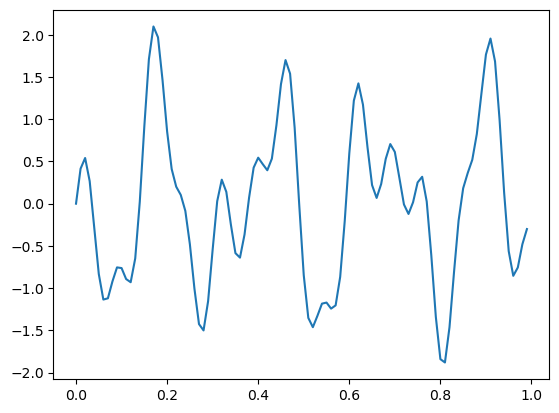

In [229]:
plt.plot(observations, target);
plt.xlabel("Time");

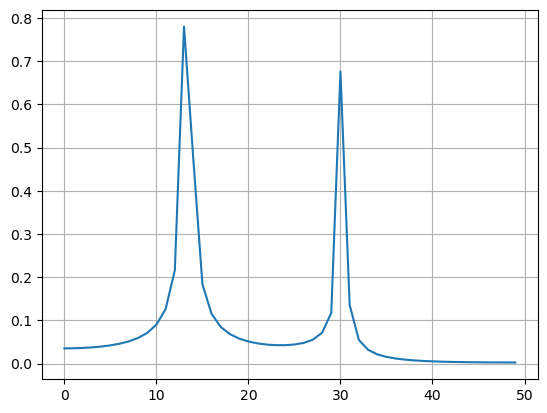

In [24]:
N = observation_resolution
T = 1.0 / N
yf = sp.fft.fft(target)
xf = sp.fft.fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]));
plt.grid();
# plt.xlim(70, 72);

(0.0, 0.11)

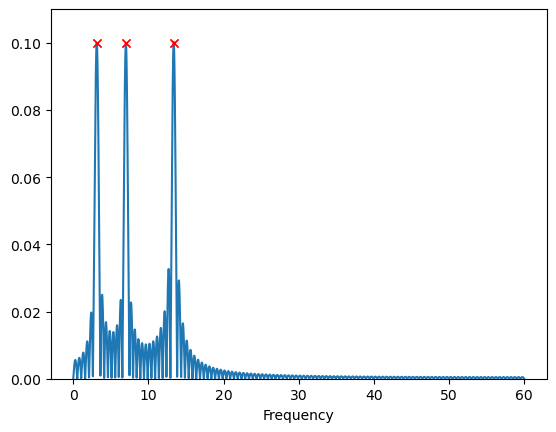

In [280]:
u_tilde = u #Measure([[6]], [0.1])
a = np.arange(Omega[0][0],Omega[0][1],0.01)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for pos in u_tilde.support:
    plt.plot(pos, np.abs(p(u_tilde)(pos)), "x", c="r");
plt.xlabel("Frequency");
plt.ylim(0,0.11)
# plt.xlim(69, 73);